<font color='tomato'><font color="#CC3D3D"><p>
# This approach has the following characteristics:
* No feature engineering
* Applying BOW to raw transactions
* Applying Denoising Autoencoder (DAE) to reduce the number of features
* Creating multiple DNNs by changing random seeds and Ensembling the models with power mean    
    
<img align='left' src='https://img1.daumcdn.net/thumb/R720x0.q80/?scode=mtistory2&fname=http%3A%2F%2Fcfile24.uf.tistory.com%2Fimage%2F992860505BDC99320A2AA2' width=600>      

In [1]:
%run import_modules.py  
%matplotlib inline

# For DNN modeling
import tensorflow as tf

# Tensorflow warning off
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
tf.logging.set_verbosity(tf.logging.ERROR)

from tensorflow import set_random_seed
import keras
from keras import backend as K
from keras.layers import * #Input, Dense
from keras.models import * #Model
from keras.optimizers import *
from keras.initializers import *
from keras.regularizers import *
from keras.utils.np_utils import *
from keras.utils.vis_utils import * #model_to_dot
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


### Read Data

In [2]:
tr_train = pd.read_csv('X_train.csv', encoding='cp949')
tr_test = pd.read_csv('X_test.csv', encoding='cp949')
y_train = pd.read_csv('y_train.csv').gender
IDtest = tr_test.cust_id.unique()

tr_train.head()

,cust_id,tran_date,store_nm,goods_id,gds_grp_nm,gds_grp_mclas_nm,amount
0,0,2007-01-19 00:00:00,강남점,127105,기초 화장품,화장품,850000
1,0,2007-03-30 00:00:00,강남점,342220,니 트,시티웨어,480000
2,0,2007-03-30 00:00:00,강남점,127105,기초 화장품,화장품,3000000
3,0,2007-03-30 00:00:00,강남점,342205,니 트,시티웨어,840000
4,0,2007-03-30 00:00:00,강남점,342220,상품군미지정,기타,20000


### Make BOW-based Features

In [3]:
features = ['goods_id', 'gds_grp_nm', 'gds_grp_mclas_nm']

tr_all = pd.concat([tr_train, tr_test])
train = []
test = []

for f in features:
    for d,q in zip([train, test], ['cust_id not in @IDtest', 'cust_id in @IDtest']):
        d.append(pd.pivot_table(tr_all, index='cust_id', columns=f, values='amount',
                                aggfunc=lambda x: np.where(len(x) >=1, 1, 0), fill_value=0)                 
                 .reset_index()
                 .query(q)
                 .drop(columns=['cust_id']).values)
 
train, test = np.hstack(train),  np.hstack(test)

train.shape, test.shape

((3500, 4179), (2482, 4179))

### Build Models with DAE

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

DAE learning curve 1/10


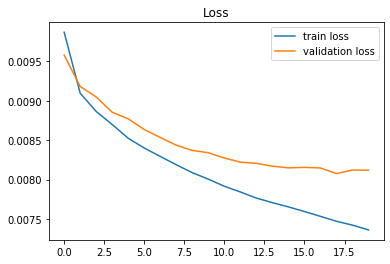

DNN learning curve 1/10


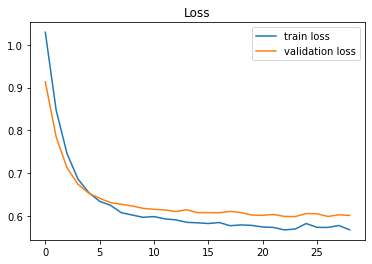

AUC 0.7297371893840727


 10%|████████▎                                                                          | 1/10 [01:32<13:51, 92.39s/it]

DAE learning curve 2/10


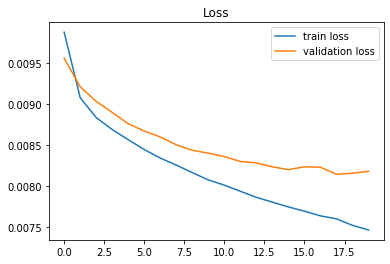

DNN learning curve 2/10


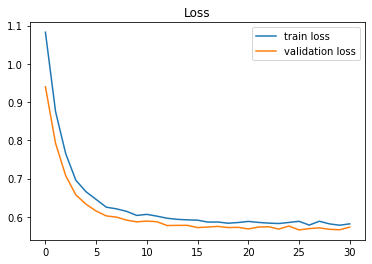

 20%|████████████████▌                                                                  | 2/10 [03:06<12:22, 92.83s/it]

AUC 0.762777665545318
DAE learning curve 3/10


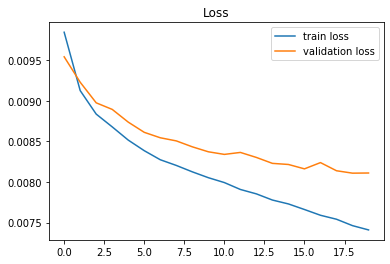

DNN learning curve 3/10


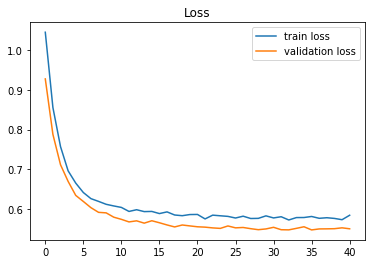

 30%|████████████████████████▉                                                          | 3/10 [04:41<10:54, 93.53s/it]

AUC 0.7879135390603281
DAE learning curve 4/10


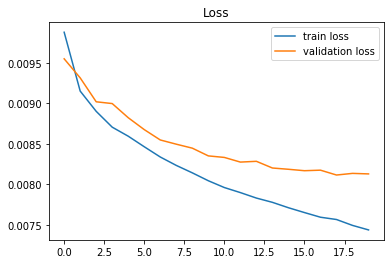

DNN learning curve 4/10


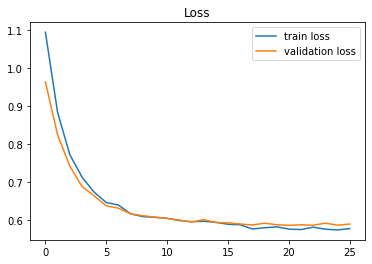

 40%|█████████████████████████████████▏                                                 | 4/10 [06:17<09:25, 94.28s/it]

AUC 0.7473655803433741
DAE learning curve 5/10


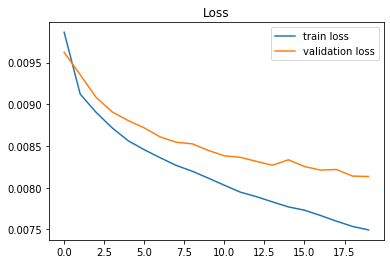

DNN learning curve 5/10


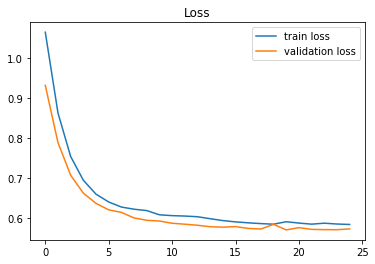

 50%|█████████████████████████████████████████▌                                         | 5/10 [07:52<07:52, 94.58s/it]

AUC 0.7619397725591877
DAE learning curve 6/10


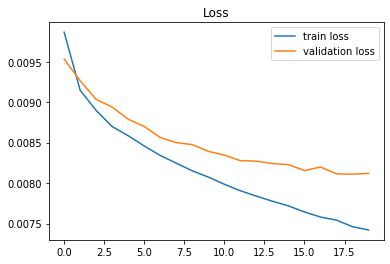

DNN learning curve 6/10


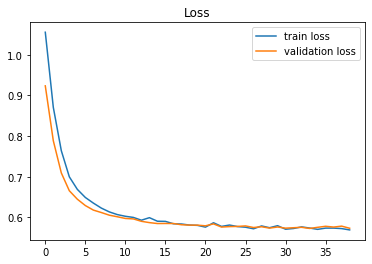

 60%|█████████████████████████████████████████████████▊                                 | 6/10 [09:30<06:22, 95.61s/it]

AUC 0.7609684148055054
DAE learning curve 7/10


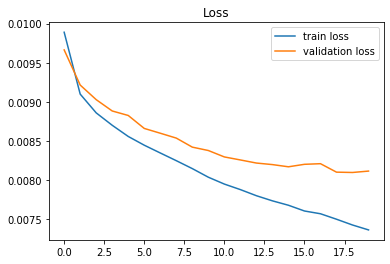

DNN learning curve 7/10


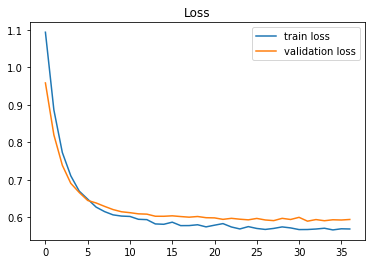

 70%|██████████████████████████████████████████████████████████                         | 7/10 [11:10<04:50, 96.85s/it]

AUC 0.7422417112299464
DAE learning curve 8/10


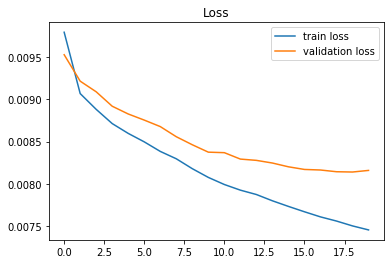

DNN learning curve 8/10


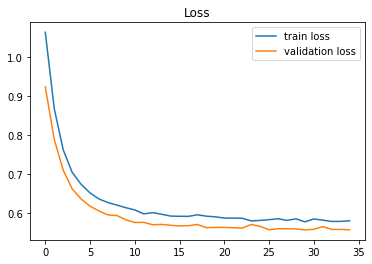

 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [12:52<03:16, 98.33s/it]

AUC 0.7650735981620496
DAE learning curve 9/10


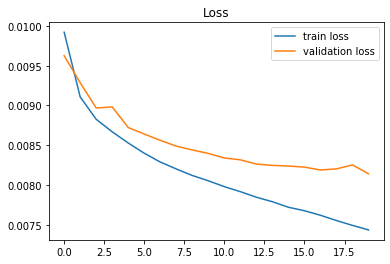

DNN learning curve 9/10


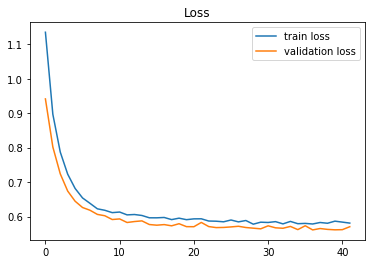

 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [14:35<01:39, 99.71s/it]

AUC 0.7546284600671262
DAE learning curve 10/10


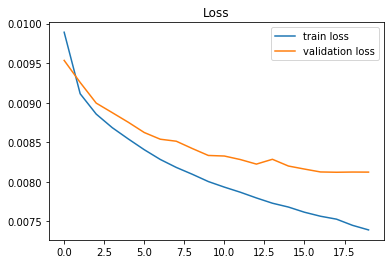

DNN learning curve 10/10


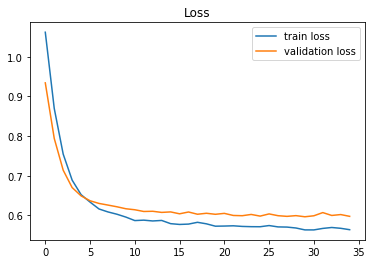

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [16:20<00:00, 98.05s/it]

AUC 0.7254763280690708

Validation Summary:
2    0.787914
7    0.765074
1    0.762778
4    0.761940
5    0.760968
8    0.754628
3    0.747366
6    0.742242
0    0.729737
9    0.725476
dtype: float64
mean=0.75381, std=0.018


In [4]:
# Set hyper-parameters for power mean ensemble 
N = 10
p = 3.5
preds = []
aucs = []

for i in tqdm(range(N)):    
    X_train, X_test = train, test

    ##### STEP 1: Randomize Seed
    SEED = np.random.randint(1, 10000)              
    random.seed(SEED)       
    np.random.seed(SEED)     
    if tf.__version__[0] < '2':  
        tf.set_random_seed(SEED)
    else:
        tf.random.set_seed(SEED)

    ##### STEP 2: Build DAE #####
    
    # Define the encoder dimension
    encoding_dim = 128

    # Input Layer
    input_dim = Input(shape = (X_train.shape[1], ))

    # Encoder Layers
    noise = Dropout(0.5)(input_dim) # for Denoising
    encoded1 = Dense(512, activation = 'relu')(noise)
    encoded2 = Dense(256, activation = 'relu')(encoded1)
    encoded3 = Dense(128, activation = 'relu')(encoded2)
    encoded4 = Dense(encoding_dim, activation = 'relu')(encoded3)

    # Decoder Layers
    decoded1 = Dense(128, activation = 'relu')(encoded4)
    decoded2 = Dense(256, activation = 'relu')(decoded1)
    decoded3 = Dense(512, activation = 'relu')(decoded2)
    decoded4 = Dense(X_train.shape[1], activation = 'linear')(decoded3)

    # Combine Encoder and Deocder layers
    autoencoder = Model(inputs = input_dim, outputs = decoded4)

    # Compile the model
    autoencoder.compile(optimizer = 'adam', loss = 'mse')

    # Train the model
    history = autoencoder.fit(X_train, X_train, epochs=20, batch_size=64, 
                              shuffle=True, validation_data=(X_test,X_test), verbose=0)

    print(f'DAE learning curve {i+1}/{N}')
    plt.plot(history.history["loss"], label="train loss")
    plt.plot(history.history["val_loss"], label="validation loss")
    plt.legend()
    plt.title("Loss")
    plt.show()

    ##### STEP 3: Reduce Dimension #####
        
    # Use a middle Bottleneck Layer to Reduce Dimension
    model = Model(inputs=input_dim, outputs=encoded4)
    X_train = model.predict(X_train)
    X_test = model.predict(X_test)

    ##### STEP 4: Build a DNN Model

    # Define the Model architecture
    model = Sequential()
    model.add(Dense(32, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.3))
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))

    # Train the Model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
    train_x, valid_x, train_y, valid_y = train_test_split(X_train, y_train, test_size=0.2)
    history = model.fit(train_x, train_y, epochs=100, batch_size=64, 
                        validation_data=(valid_x,valid_y), callbacks=[EarlyStopping(patience=5)], verbose=0)

    print(f'DNN learning curve {i+1}/{N}')
    plt.plot(history.history["loss"], label="train loss")
    plt.plot(history.history["val_loss"], label="validation loss")
    plt.legend()
    plt.title("Loss")
    plt.show()
    
    # Make Prediction
    auc = roc_auc_score(valid_y, model.predict(valid_x).flatten())
    aucs.append(auc)
    print('AUC', auc)
    preds.append(model.predict(X_test).flatten())   

### Validate the Models
print('\nValidation Summary:')
aucs = pd.Series(aucs)
print(aucs.sort_values(ascending=False))
print('mean={:.5f}, std={:.3f}'.format(aucs.mean(), aucs.std()))     

### Ensemble Models & Make Submissions

In [6]:
# Power mean ensemble
THRESHOLD = 0.77  # Use only models whose AUC exceeds this value

pred = 0
n = 0
for i in range(N):
    if aucs.iloc[i] > THRESHOLD:
        pred = pred + preds[i]**p 
        n += 1
pred = pred / n    
pred = pred**(1/p)

# Make a submission file
t = pd.Timestamp.now()
fname = f"dae_p{p}n{n}_submit_{t.month:02}{t.day:02}{t.hour:02}{t.minute:02}.csv"
submissions = pd.concat([pd.Series(IDtest, name="cust_id"), pd.Series(pred, name="gender")] ,axis=1)
submissions.to_csv(fname, index=False)
print(f"'{fname}' is ready to submit.")

'dae_p3.5n5_submit_06111502.csv' is ready to submit.


<font color='tomato'><font color="#CC3D3D"><p>
# End